In [1]:
import numpy as np
import math
import pandas as pd
import os.path

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from keras import Model
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.layers import Concatenate, Add, Activation, Multiply, Lambda
from keras.optimizers import Adam, RMSprop
from keras.losses import mean_squared_error, mean_absolute_error
from keras.models import load_model
from keras.utils import Sequence
import keras.backend as K

import matplotlib.pyplot as plt

from IPython.display import Markdown, display



Using TensorFlow backend.


In [2]:

# Training/test data - adjust for local system
SRC_DIR = "../data/"

trainingFile = SRC_DIR + "/all_train.csv"
testingFile = SRC_DIR + "/all_test.csv"

# Optional - compare against submitted entry
compareFile = "../submissions/base.csv"




In [3]:

def fixFeatures(frame, fixMode):
    
    combine = [
     [ 'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_d_air'],
        
     [ 'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_d_level' ], 
           
               
     [  'rougher.state.floatbank10_a_air',
        'rougher.state.floatbank10_b_air',
        'rougher.state.floatbank10_c_air',
        'rougher.state.floatbank10_d_air',
        'rougher.state.floatbank10_e_air',
        'rougher.state.floatbank10_f_air', ],
        
     [ 'rougher.state.floatbank10_a_level',
       'rougher.state.floatbank10_b_level', 
       'rougher.state.floatbank10_c_level', 
       'rougher.state.floatbank10_d_level', 
       'rougher.state.floatbank10_e_level', 
       'rougher.state.floatbank10_f_level', ],
               
      ['secondary_cleaner.state.floatbank2_a_air',
       'secondary_cleaner.state.floatbank2_b_air',
       'secondary_cleaner.state.floatbank3_a_air',
       'secondary_cleaner.state.floatbank3_b_air',
       'secondary_cleaner.state.floatbank4_a_air',
       'secondary_cleaner.state.floatbank4_b_air',
       'secondary_cleaner.state.floatbank5_a_air',
       'secondary_cleaner.state.floatbank5_b_air',
       'secondary_cleaner.state.floatbank6_a_air',],
        
       ['secondary_cleaner.state.floatbank2_a_level',
       'secondary_cleaner.state.floatbank2_b_level',
       'secondary_cleaner.state.floatbank3_a_level',
       'secondary_cleaner.state.floatbank3_b_level',
       'secondary_cleaner.state.floatbank4_a_level',
       'secondary_cleaner.state.floatbank4_b_level',
       'secondary_cleaner.state.floatbank5_a_level',
       'secondary_cleaner.state.floatbank5_b_level',
       'secondary_cleaner.state.floatbank6_a_level',],        
    ]
       
    # Replace separate channels with aggregates
    
    if fixMode!='NoFix':
        filled = frame.fillna(method='ffill')
        for i,c in enumerate(combine):                 
            frame['combine' + str(i)] = filled[c].values.mean(axis=1)       
            if (fixMode=='FixReplace'):
                frame.drop(columns=c, inplace=True)
    return frame

In [4]:
#fixMode = 'NoFix'
fixMode = 'FixReplace'
#fixMode = 'Fix'


frame = fixFeatures(pd.read_csv(trainingFile), fixMode)
#print(frame.columns)

test = pd.read_csv(testingFile)
testDate = test['date']
test = fixFeatures(test, fixMode)
test.columns

Index(['date', 'primary_cleaner.input.copper_sulfate',
       'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
       'primary_cleaner.input.xanthate', 'rougher.input.feed_fe',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_zn', 'rougher.input.floatbank10_copper_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_copper_sulfate',
       'rougher.input.floatbank11_xanthate', 'combine0', 'combine1',
       'combine2', 'combine3', 'combine4', 'combine5'],
      dtype='object')

In [5]:
allOutputs = [
    'rougher.output.recovery',
    'final.output.recovery',
    
    'rougher.output.concentrate_fe',
    'rougher.output.concentrate_pb',
    'rougher.output.concentrate_sol',
    'rougher.output.concentrate_zn',                                                      
    'rougher.output.tail_fe',
    'rougher.output.tail_pb',
    'rougher.output.tail_sol',
    'rougher.output.tail_zn',

    'primary_cleaner.output.concentrate_fe',
    'primary_cleaner.output.concentrate_pb',
    'primary_cleaner.output.concentrate_sol',
    'primary_cleaner.output.concentrate_zn',
    
    'primary_cleaner.output.tail_fe', 
    'primary_cleaner.output.tail_pb',
    'primary_cleaner.output.tail_sol',
    'primary_cleaner.output.tail_zn',

    'final.output.concentrate_fe', 
    'final.output.concentrate_pb',
    'final.output.concentrate_sol',
    'final.output.concentrate_zn',
    
    'secondary_cleaner.output.tail_fe',
    'secondary_cleaner.output.tail_pb',
    'secondary_cleaner.output.tail_sol',
    'secondary_cleaner.output.tail_zn',  
]

In [6]:
# Skip date
inVals = frame[test.columns[1:]]
insValid = inVals.notna().all(axis=1).values
# If any of the main variables is bad, then don't use for training...
znValid = (inVals['rougher.input.feed_zn'].notna().values *
           inVals['rougher.input.feed_size'].notna().values *
           inVals['rougher.input.feed_rate'].notna().values
          )
#How much is left?
print("Zn valid:", znValid.mean())

#Forward fill to preserve causality 
inVals = inVals.fillna(method='ffill').values
allOutVals = frame[allOutputs]
outsValid = allOutVals.notna().all(axis=1).values
allOutVals = allOutVals.fillna(method='ffill').values


inMean = inVals.mean(axis=0)
inStd = inVals.std(axis=0)

allOutStd = allOutVals.std(axis=0)
allOutMean = allOutVals.mean(axis=0)


outMean = allOutMean[0:2]
outStd = allOutStd[0:2]

# Normalized
vals_x = (inVals-inMean)/inStd
vals_y = (allOutVals-allOutMean)/allOutStd

valid = insValid * outsValid

print("Valid", valid.mean(), "in:", insValid.mean(), "outs:", outsValid.mean())
print("Out Scale", outStd[0:2])

testInsValid = test.notna().all(axis=1).values
print('Test inputs valid', testInsValid.mean())


Zn valid: 0.9491696322657177
Valid 0.6806049822064056 in: 0.8447805456702254 outs: 0.7189798339264531
Out Scale [18.61226981 13.34912456]
Test inputs valid 0.9219603825136612


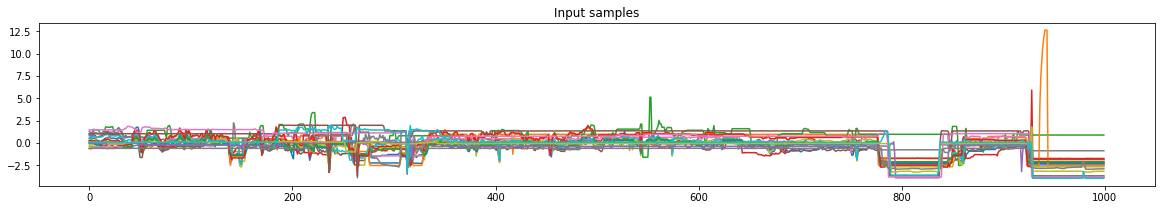

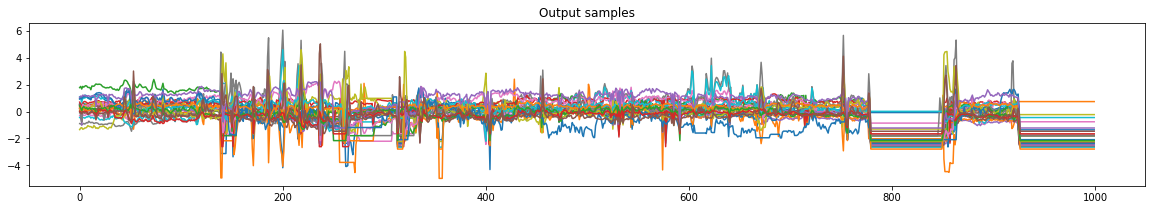

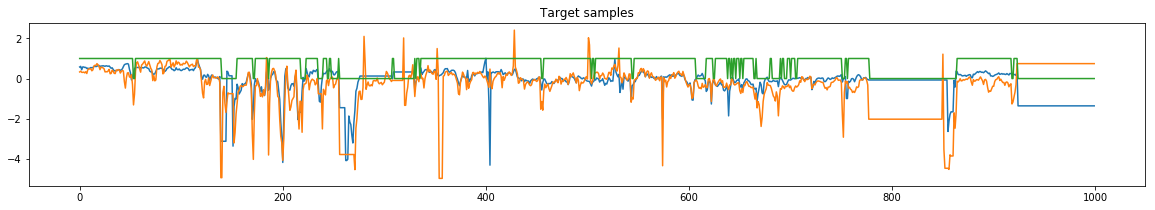

In [7]:
show0 = 1000
show1 = 2000
plt.figure(figsize=(20,3))
plt.gca().set_title("Input samples")
for col in range(vals_x.shape[1]):
    plt.plot(vals_x[show0:show1,col])
plt.show()

plt.figure(figsize=(20,3))
plt.gca().set_title("Output samples")
for col in range(vals_y.shape[1]):
    plt.plot(vals_y[show0:show1,col])
plt.show()

plt.figure(figsize=(20,3))
plt.gca().set_title("Target samples")
for col in range(2):
    plt.plot(vals_y[show0:show1,col])
plt.plot(outsValid[show0:show1])
plt.show()

Valid samples: 11982 -> 9886
Training: 6899 Validation: 1145 Test: 751


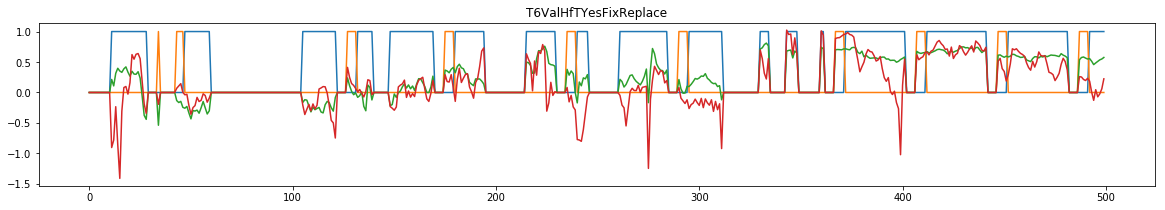

In [8]:
#Time steps to use
T = 6

# Split between traning and validation set.
#
# Use large splitTrain to train on all the data

# Hold back a test set (False = for developement) or use all data (True = for submission)
# I'm not actually sure if the submission had this set to True or False, but True should get better results on average.
trainOnAllData = False

testMode = "TNo" if trainOnAllData else "TYes"


#dataMode = "ValNone"
dataMode = "ValHf"
#dataMode = "ValLf"


if dataMode=="ValNone":
    # Don't need a validation set here, since we are using a fixed training schedule, so use all for training
    #  by making the split bigger than the total data
    splitTrain = 30000
    splitValid = 4
    allowOverlap = False
elif dataMode=="ValHf":
    #Do high frequency splitting of train/test interleaving
    splitTrain = 30
    splitValid = 4
    allowOverlap = False
elif dataMode=="ValLf":
    #Do low frequency splitting of train/test interleaving
    splitTrain = 300
    splitValid = 40
    allowOverlap = False
else:
    raise ValueError('Unknown data mode:' + dataMode)

dataName = "T" + str(T) + dataMode + testMode + fixMode
    

# From an array of input values, first duplicate the first inputs (T-1) times
# Then take runs of T inputs to form rows with the inputs at time t,  plus T-1 previous inputs 
def expand(ins):
    padded = np.concatenate( [ np.tile(ins[0], (T-1,1) ), ins ], axis=0 )
    N = padded.shape[0]
    return np.concatenate( [padded[o:o+N-T+1] for o in range(T) ], axis=1)

# If the output or the zn valid are invalid, the sequence is invalid
seqValid = np.copy(outsValid) * znValid
    
was = seqValid.sum()
# The sequence is invalid if any of the previous (T-1) steps were invalid
for t in range(T-1):
    seqValid[1:] *= seqValid[:-1]
    seqValid[0] = 0

print("Valid samples:", was,"->",seqValid.sum())


N = vals_y.shape[0]
seqIns = expand(vals_x)
seqOuts = vals_y

isTraining = np.zeros(N)
isTesting = np.zeros(N)
train_xlist = []
train_ylist = []
valid_xlist =[]
valid_ylist =[]
test_xlist =[]
test_ylist =[]

# Hold some back for testing?
testStart = N  * (2 if trainOnAllData else 0.85)

tfill = 0
vfill = 0
valStart = -100
prevTrain = -1

# Place values in train/test/valid
# Don't take random samples, but instead ensure that the train and validation samples do not overlap in time
for idx in range(N):
    if seqValid[idx]:
        if idx>testStart:
            test_xlist.append(seqIns[idx])
            test_ylist.append(seqOuts[idx])
        elif tfill<splitTrain:
            if prevTrain<0:
                prevTrain = idx
            # take 2 values for use in augmentation
            train_xlist.append( (seqIns[idx],seqIns[prevTrain]) )
            train_ylist.append( (seqOuts[idx],seqOuts[prevTrain]) )
            prevTrain = idx
            isTraining[idx] = 1
            if not allowOverlap:
                valStart = idx+T
            tfill+=1
        elif idx>=valStart:
            prevTrain = -1
            isTesting[idx] = 1
            valid_xlist.append(seqIns[idx])
            valid_ylist.append(seqOuts[idx])
            vfill+=1
            if vfill>splitValid:
                vfill = tfill = 0
    else:
        prevTrain = -1
  
print("Training:",len(train_xlist), "Validation:", len(valid_xlist), "Test:", len(test_xlist))
train_x = np.array(train_xlist, dtype=np.float)
train_y = np.array(train_ylist, dtype=np.float)
valid_x = np.array(valid_xlist, dtype=np.float)
valid_y = np.array(valid_ylist, dtype=np.float)
test_x = np.array(test_xlist, dtype=np.float)
test_y = np.array(test_ylist, dtype=np.float)
    


v0 = 500
v1 = 1000
plt.figure(figsize=(20,3))
plt.gca().set_title(dataName)
#plt.plot(outsValid[v0:v1]*znValid[v0:v1])
#plt.plot(seconds[v0:v1])
plt.plot(isTraining[v0:v1])
plt.plot(isTesting[v0:v1])
plt.plot(vals_y[v0:v1,0] * (1 - (1-isTraining[v0:v1]) * (1-isTesting[v0:v1])) )
plt.plot(vals_y[v0:v1,1] * (1 - (1-isTraining[v0:v1]) * (1-isTesting[v0:v1])) )
plt.show()

In [9]:
def createModel2(ins,outs,dropout=0.0,loss='mse',fdo=0.0):
    i = Input(shape=(ins,),name="input" )
    x = i
    dim = 512
    x = Dense(dim,activation='relu',name="expand")(x)
    x0 = x
    for scale in range(1,3):
        name = "d" + str(scale)
        x0 = x
        x = Dense(dim,activation='linear', name=name+"1")(x)
        x = BatchNormalization(axis=-1,name=name + "bn1" )(x)
        x = Activation("relu")(x)
        if (dropout>0):
            d=Dropout(dropout)(x)
        x = Dense(dim,activation='linear', name=name+"2")(x) 
        x = BatchNormalization(axis=-1,name=name+"bn2")(x)

        x = Add(name="add" + str(scale))([x0,x])
        x = Activation("relu")(x)
        
    auxOut = Dense(outs-2,activation='linear',name="aux" )(x)
    
    
    state = Dense(dim-ins-outs+2,activation='relu',name="state")(x)
    x = Concatenate()([i,auxOut,state])
    
    for scale in range(3,5):
        name = "d" + str(scale)
        x0 = x
        x = Dense(dim,activation='linear', name=name+"1")(x)
        x = BatchNormalization(axis=-1,name=name + "bn1" )(x)
        x = Activation("relu")(x)
        if (dropout>0):
            d=Dropout(dropout)(x)
        x = Dense(dim,activation='linear', name=name+"2")(x) 
        x = BatchNormalization(axis=-1,name=name+"bn2")(x)

        x = Add(name="add" + str(scale))([x0,x])
        x = Activation("relu")(x)

    
    x = Dense(768,activation='relu',name="preout")(x)
    if fdo>0:
        x = Dropout(fdo)(x)
    x = Dense(2,activation='linear',name="recovery" )(x)
        
    model = Model(inputs=i, outputs=[x,auxOut] )
    model.compile(loss=loss, optimizer="adam")

    return model



#def runModel(model,ins):
#    vals_xt = expand((ins-inMean)/inStd)
#    return np.clip(model.predict(vals_xt)*outStd + outMean,0,100)



In [10]:
def srcGenerator2(vals_x, vals_y0, vals_y1, batch_size, augMode):
    n = vals_x.shape[0]
    shuffle_indices = np.arange(n)
    xsize = vals_x.shape[2]
    y0size = vals_y0.shape[2]
    y1size = vals_y1.shape[2]

    while True:
        shuffle_indices = np.random.permutation(shuffle_indices)

        for start in range(0, n, batch_size):
            end = min(start + batch_size, n)
            count = end-start
            
            src_batch = np.empty( (count,xsize), dtype=np.float32)
            target0_batch = np.empty( (count,y0size), dtype=np.float32)
            target1_batch = np.empty( (count,y1size), dtype=np.float32)

            for i in range(count):
                sid = shuffle_indices[start+i]
                # augmentation by mixing linearly between samples
                if augMode=='Lin':
                    blend = np.random.random()
                elif augMode=='Cos':
                    blend = np.cos( np.random.random()*math.pi )*0.5 + 0.5
                elif augMode=='Sqr':
                    blend = (1-np.random.random() * np.random.random())*0.5
                elif augMode=='NoAug':
                    blend = 0
                else:
                    raise ValueError("Bad augMode:" + augMode)
                
                src_batch[i] = vals_x[sid,0] + (vals_x[sid,1] - vals_x[sid,0]) * blend
                target0_batch[i] = vals_y0[sid,0]  + (vals_y0[sid,1] - vals_y0[sid,0]) * blend
                target1_batch[i] = vals_y1[sid,0]  + (vals_y1[sid,1] - vals_y1[sid,0]) * blend                
                
            yield src_batch, [target0_batch, target1_batch]

In [11]:
def runModel(m,x):
    return np.clip( m.predict(x)[0]*allOutStd[0:2] + allOutMean[0:2],0, 100)

def runModelRaw(m,ins):
    vals_xt = expand((ins-inMean)/inStd)
    return runModel(m,vals_xt)

Final outs: (6899, 2, 2) (6899, 2, 24)
Training T6ValHfTYesFixReplace -> T6ValHfTYesFixReplaceBs256Do20FDo30Lin
Epoch 1/100
 - 6s - loss: 0.5925 - recovery_loss: 0.3090 - aux_loss: 0.2835 - val_loss: 0.4683 - val_recovery_loss: 0.2213 - val_aux_loss: 0.2470
Epoch 2/100
 - 3s - loss: 0.3479 - recovery_loss: 0.1713 - aux_loss: 0.1766 - val_loss: 0.4235 - val_recovery_loss: 0.2037 - val_aux_loss: 0.2198
Epoch 3/100
 - 3s - loss: 0.2976 - recovery_loss: 0.1438 - aux_loss: 0.1538 - val_loss: 0.4177 - val_recovery_loss: 0.2121 - val_aux_loss: 0.2056
Epoch 4/100
 - 3s - loss: 0.2687 - recovery_loss: 0.1286 - aux_loss: 0.1401 - val_loss: 0.4129 - val_recovery_loss: 0.2082 - val_aux_loss: 0.2047
Epoch 5/100
 - 3s - loss: 0.2505 - recovery_loss: 0.1197 - aux_loss: 0.1309 - val_loss: 0.4001 - val_recovery_loss: 0.2009 - val_aux_loss: 0.1992
Epoch 6/100
 - 3s - loss: 0.2363 - recovery_loss: 0.1136 - aux_loss: 0.1227 - val_loss: 0.3981 - val_recovery_loss: 0.2052 - val_aux_loss: 0.1929
Epoch 7/100


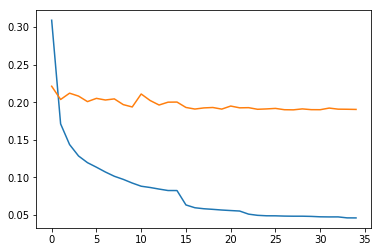

In [12]:
final_outs0 = train_y[:,:,0:2]
final_outs1 = train_y[:,:,2:]
if valid_y.shape[0]>0:
    final_valid0 = valid_y[:,0:2]
    final_valid1 = valid_y[:,2:]
if test_y.shape[0]>0:
    final_test0 = test_y[:,0:2]
    final_test1 = test_y[:,2:]
    

print("Final outs:", final_outs0.shape,final_outs1.shape, )

BATCH_SIZE = 256
DropOut = 0.2
FinalDropOut = 0.3
augMode = "Lin"
#augMode = "NoAug"
#augMode = "Cos"  # Beta?
#augMode = "Sqr"

trainName = dataName + "Bs" + str(BATCH_SIZE) + "Do" + str( (int)(DropOut*100)) + "FDo" + str( (int)(FinalDropOut*100)) + augMode

def schedule(e):
    if e<25:
        return 0.001000
    if e<40:
        return 0.000250
    if e<45:
        return 0.000050
    return     0.000010


if trainOnAllData:
    callbacks = [
        LearningRateScheduler(schedule, verbose=0)
    ]
else:
    lossName = "val_recovery_loss"
    callbacks = [EarlyStopping(monitor=lossName, patience=7,verbose=1,min_delta=1e-4,mode='min'),
             ReduceLROnPlateau(monitor=lossName, factor=0.2,patience=5,verbose=1,min_delta=1e-4,  mode='min'),
            ]

    

trainBatches = int( math.ceil( train_x.shape[0]/ (32) ) )

refined = createModel2(train_x.shape[-1],train_y.shape[-1],DropOut,mean_absolute_error,FinalDropOut)

if valid_y.shape[0]>0:
    validation_data=(valid_x, [final_valid0, final_valid1 ])
else:
    validation_data=(test_x, [final_test0, final_test1 ]) if test_y.shape[0]>0 else ( )
    
print("Training", dataName, "->", trainName)

hist = refined.fit_generator( srcGenerator2(train_x, final_outs0, final_outs1,BATCH_SIZE,augMode ),
              steps_per_epoch=trainBatches,
              epochs=30 if trainOnAllData else 100,
              verbose=2,
              callbacks=callbacks,
              validation_data=validation_data
            )


plt.plot(hist.history["recovery_loss"])
if not trainOnAllData:
    plt.plot(hist.history[lossName])
plt.show()


In [13]:
#Run
testR = runModelRaw(refined,test.values[:,1:])
#Glue on the dates
testFrame = pd.DataFrame(testR,columns=['rougher.output.recovery','final.output.recovery' ])
result = pd.concat([testDate,testFrame],axis=1)
#Save

outputFile = "../submissions/" + trainName + ".csv"

if os.path.isfile(outputFile):
    display(Markdown("# FILE EXISTS! - not overwriting"))
else:
    result.to_csv(outputFile,index=False, sep=',', encoding='utf-8')
    print("Saved",outputFile)


Saved ../submissions/T6ValHfTYesFixReplaceBs256Do20FDo30Lin.csv


Test Err 8.104796437745252
Test Abs 5.572161989734923


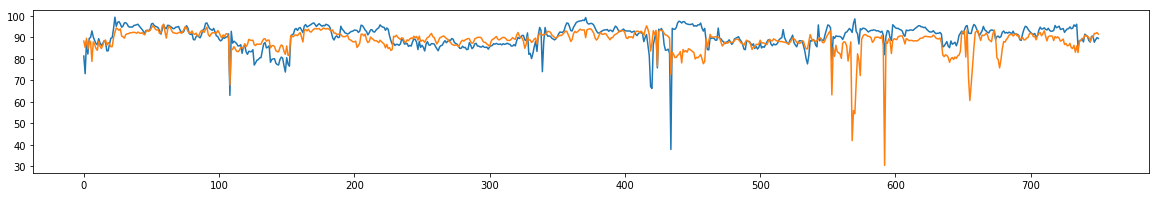

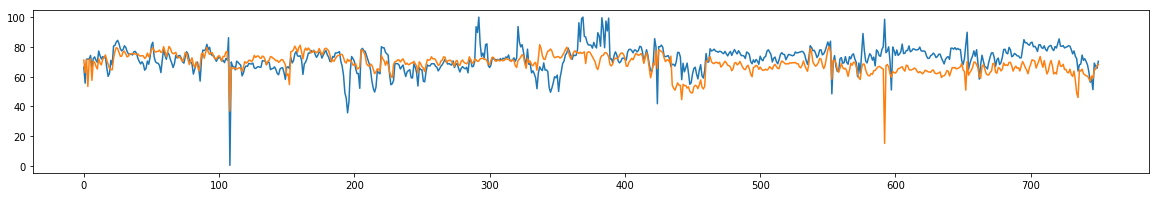

In [14]:
if (not trainOnAllData):
    pred = runModel(refined,test_x)
    ref = (test_y*allOutStd+allOutMean)[:,0:2]

    print("Test Err", np.sqrt( np.square(pred-ref).mean())  )
    print("Test Abs", np.abs(pred-ref).mean() )
    val_loss = hist.history["val_recovery_loss"]

    plt.figure(figsize=(20,3))
    plt.plot(ref[:,0])
    plt.plot(pred[:,0])
    plt.show()
    plt.figure(figsize=(20,3))
    plt.plot(ref[:,1])
    plt.plot(pred[:,1])
    plt.show()

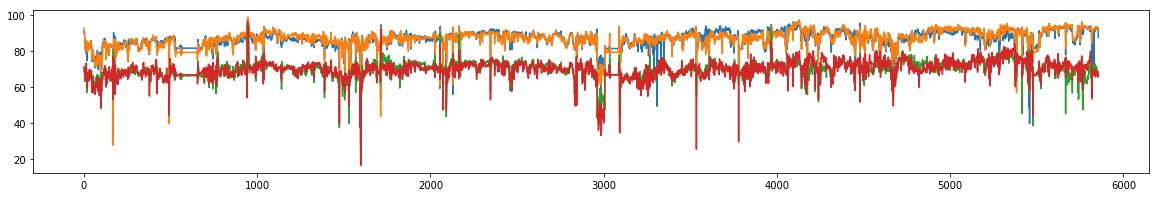

In [15]:
# Compare to official entry

if os.path.isfile(compareFile):
    prevResult = pd.read_csv(compareFile).values[:,1:]

    plt.figure(figsize=(20,3))
    plt.plot(testR[:,0])
    plt.plot(prevResult[:,0])

    plt.plot(testR[:,1])
    plt.plot(prevResult[:,1])
    plt.show()